<a href="https://colab.research.google.com/github/AliceKitchkin/Unsupervised-Machine-Learning/blob/main/AirlinePassengerSatisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Bibliotheken und Daten Import

---

In [147]:
# handle table-like data and matrices
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# preprocessing
from sklearn.preprocessing import StandardScaler

# pca
from sklearn.decomposition import PCA

# clustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering

# evaluations
from sklearn.metrics import confusion_matrix

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# to display the total number columns present in the dataset
pd.set_option('display.max_columns', None)

In [148]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [149]:
data_raw = pd.read_csv("/content/drive/MyDrive/Bachelorarbeit/CSV/Airline Passenger Satisfaction/AirlinePassengerData_Test.csv")
data = data_raw.copy()

#2. Aufbereitung

---

##2.1 First Look

In [150]:
data_raw.head(5)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,satisfied


In [151]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         25976 non-null  int64  
 1   id                                 25976 non-null  int64  
 2   Gender                             25976 non-null  object 
 3   Customer Type                      25976 non-null  object 
 4   Age                                25976 non-null  int64  
 5   Type of Travel                     25976 non-null  object 
 6   Class                              25976 non-null  object 
 7   Flight Distance                    25976 non-null  int64  
 8   Inflight wifi service              25976 non-null  int64  
 9   Departure/Arrival time convenient  25976 non-null  int64  
 10  Ease of Online booking             25976 non-null  int64  
 11  Gate location                      25976 non-null  int

In [152]:
data_raw.shape

(25976, 25)

In [153]:
data_raw.describe(include = 'all')

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,25976.000000,25976.000000,25976,25976,25976.000000,25976,25976,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.00000,25893.000000,25976
unique,NaN,NaN,2,2,NaN,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,Female,Loyal Customer,NaN,Business travel,Business,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neutral or dissatisfied
freq,NaN,NaN,13172,21177,NaN,18038,12495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14573
mean,12987.500000,65005.657992,NaN,NaN,39.620958,NaN,NaN,1193.788459,2.724746,3.046812,2.756775,2.977094,3.215353,3.261665,3.449222,3.357753,3.385664,3.350169,3.633238,3.314175,3.649253,3.286226,14.30609,14.740857,NaN
std,7498.769632,37611.526647,NaN,NaN,15.135685,NaN,NaN,998.683999,1.335384,1.533371,1.412951,1.282133,1.331506,1.355536,1.320090,1.338299,1.282088,1.318862,1.176525,1.269332,1.180681,1.319330,37.42316,37.517539,NaN
min,0.000000,17.000000,NaN,NaN,7.000000,NaN,NaN,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,NaN
25%,6493.750000,32170.500000,NaN,NaN,27.000000,NaN,NaN,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.00000,0.000000,NaN
50%,12987.500000,65319.500000,NaN,NaN,40.000000,NaN,NaN,849.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.00000,0.000000,NaN
75%,19481.250000,97584.250000,NaN,NaN,51.000000,NaN,NaN,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.00000,13.000000,NaN


##2.2 Missing Values

Missingno is a Python library that provides the ability to understand the distribution of missing values through informative visualizations.

In [154]:
print(data_raw.isna().sum())

Unnamed: 0                            0
id                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0


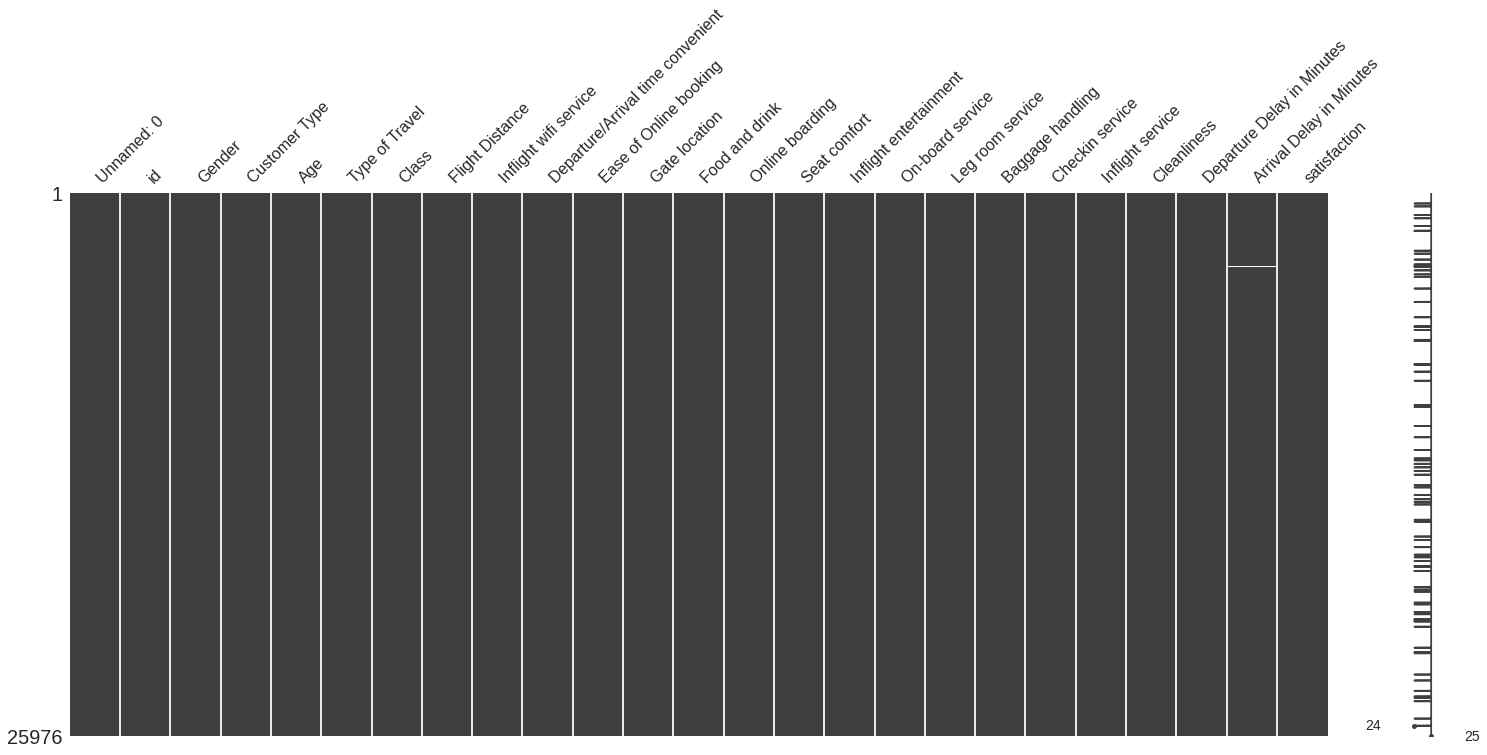

In [155]:
msno.matrix(data_raw)

Die Spalte "Arrival Delay in Minutes" (Ankunftsverspätung in Minuten) hat 83 fehlende Werte.

In [156]:
#Zeilen mit fehlenden Werten löschen
data = data.dropna()
data.isna().sum()

Unnamed: 0                           0
id                                   0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

##2.3 Spaltenaufarbeitung

In [157]:
data['Gesamtzufriedenheit summiert'] = data['Inflight wifi service'] + data['Departure/Arrival time convenient'] + data['Ease of Online booking'] + data['Gate location'] + data['Food and drink'] + data['Online boarding'] + data['Seat comfort'] + data['Inflight entertainment'] + data['On-board service'] + data['Leg room service'] + data['Baggage handling'] + data['Checkin service'] + data['Inflight service'] + data['Cleanliness']

In [158]:
#Neue Spalte "Flugverspatung in Minuten" hinzufügen
#Die im Flug aufgeholte Zeit in Minuten ist positiv
#Die im Flug noch zusätzliche Verspätung ist negativ
data['Flugverspatung in Minuten'] = data['Arrival Delay in Minutes'] - data['Departure Delay in Minutes']

In [159]:
data['Ist Puenktlich angekommen'] = np.where((data['Arrival Delay in Minutes'] - data['Departure Delay in Minutes'])==0, 1, 0)

In [160]:
#Erste Spalte "Unnamed: 0" löschen, ist bloß ein Zeilenzähler
data = data.drop("Unnamed: 0", axis=1)

In [161]:
data['Ist Kind'] = np.where(data.Age<13 , 1, 0)

In [162]:
data['Ist Erwachsener'] = np.where(data.Age>=18 , 1, 0)

In [163]:
data['Ist Kind'] = np.where((data.Age>12) & (data.Age<18), 1, 0)

In [164]:
#umbenennen
data = data.rename({"id":"id", "Gender":"Geschlecht", "Customer Type":"Passagier Typ", "Age":"Alter", "Type of Travel":"Reisetyp", "Class":"Klasse", "Flight Distance":"Flugdistanz", "Inflight wifi service":"Internet auf dem Flug", "Departure/Arrival time convenient":"Abreise/Ankunft Bequemlichkeit", "Ease of Online booking":"Leichtigkeit Online Buchung", "Gate location":"Standort Gate", "Food and drink":"Essen und Trinken", "Online boarding":"Online Boarding", "Seat comfort":"Sitzkomfort", "Inflight entertainment":"Flugentertainment", "On-board service":"On-borading Service", "Leg room service":"Beinfreiheit", "Baggage handling":"Gepaeckumgang", "Checkin service":"Checkin Service", "Inflight service":"Flugservice", "Cleanliness":"Sauberkeit", "Departure Delay in Minutes":"Abflugverspaetung in Minuten", "Arrival Delay in Minutes":"Gesamtverspätung in Minuten", "satisfaction":"Ist zufrieden"}, axis=1)

In [175]:
data.head()

,id,Geschlecht,Passagier Typ,Alter,Reisetyp,Klasse,Flugdistanz,Internet auf dem Flug,Abreise/Ankunft Bequemlichkeit,Leichtigkeit Online Buchung,Standort Gate,Essen und Trinken,Online Boarding,Sitzkomfort,Flugentertainment,On-borading Service,Beinfreiheit,Gepaeckumgang,Checkin Service,Flugservice,Sauberkeit,Abflugverspaetung in Minuten,Gesamtverspätung in Minuten,Ist zufrieden,Gesamtzufriedenheit summiert,Flugverspatung in Minuten,Ist Puenktlich angekommen,Ist Kind,Ist Erwachsener
0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,satisfied,58,-6.0,0,0,1
1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,satisfied,48,0.0,1,0,1
2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied,30,0.0,1,0,1
3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,satisfied,25,6.0,0,0,1
4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,satisfied,37,20.0,0,0,1


##2.4 Check for Unique Values

In [166]:
for col in data:
    print(data[col].unique())

[19556 90035 12360 ... 37675 90086 34799]
['Female' 'Male']
['Loyal Customer' 'disloyal Customer']
[52 36 20 44 49 16 77 43 47 46 33 60 50 31 55 25 30 62 24 22 51 56 41 53
 12 39 32 40 42 28 59 58 27 67 70 66 19 69 35 54 26 61 21 37 45 38  7 34
 17 15 48 13 11 29  8 18 23 65 57 80 64  9 14 68 10 79 63 73 74 71 72 76
 78 75 85]
['Business travel' 'Personal Travel']
['Eco' 'Business' 'Eco Plus']
[ 160 2863  192 ... 3714 3097 3518]
[5 1 2 0 3 4]
[4 1 0 3 5 2]
[3 2 0 4 5 1]
[4 1 2 3 5]
[3 5 2 4 1 0]
[4 2 1 5 3 0]
[3 5 2 4 1]
[5 4 2 1 3 0]
[5 4 1 2 3 0]
[5 4 1 2 3 0]
[5 4 3 1 2]
[2 3 4 1 5]
[5 4 2 1 3 0]
[5 2 4 3 1 0]
[  50    0   77    1   28   29   18  117   10    5    2    8   21    3
   40   80   73    4  116   59   92   20   17   30   66    9    6   14
   49   44   24    7   83   13   62   16   27   94   93  180   86   82
   32  100   25   34   90   23  168   96   45   35   85   11   26  102
   12   33   19   15   57   51  243  152   38   42   47   60   91   52
  238  150   37   71   8

##2.5 Ausreißer erkunden

###2.5.1 Alter

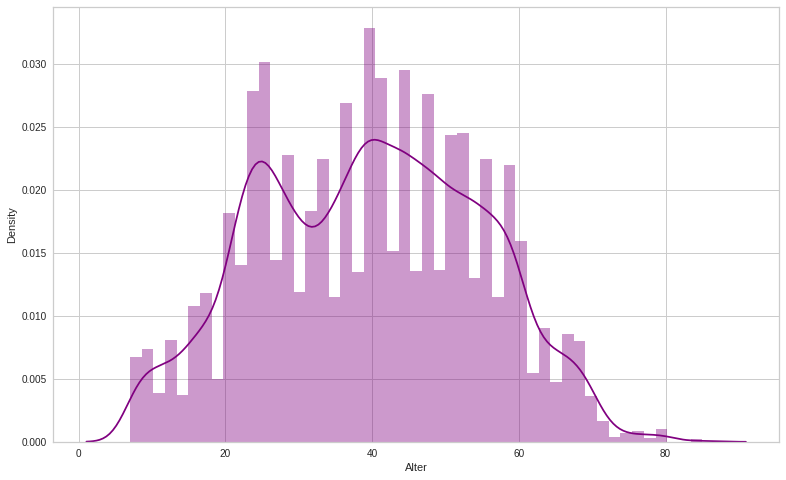

In [167]:
plt.figure(figsize=(13,8))
sns.distplot(data.Alter, color='purple');

In [168]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Box(y=data['Alter'], notched=True, name='Alter', marker_color = '#6699ff', 
                     boxmean=True, boxpoints='suspectedoutliers'), 1, 2)

fig.update_layout(title_text='Boxplot für das Alter')

fig.show()

###2.5.2 Flugdistanz

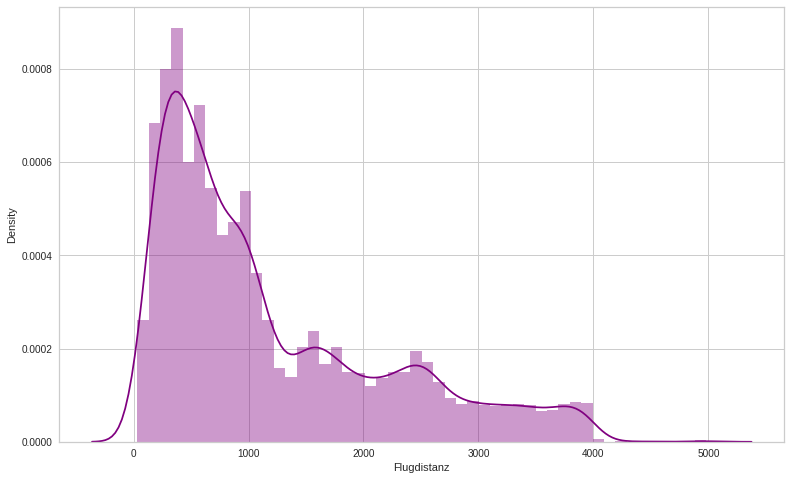

In [169]:
plt.figure(figsize=(13,8))
sns.distplot(data.Flugdistanz, color='purple');

In [170]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Box(y=data['Flugdistanz'], notched=True, name='Flugdistanz', marker_color = '#6699ff', 
                     boxmean=True, boxpoints='suspectedoutliers'), 1, 2)

fig.update_layout(title_text='Boxplot für die Flugdistanz')

fig.show()

###2.5.3 Gesamtverspätung

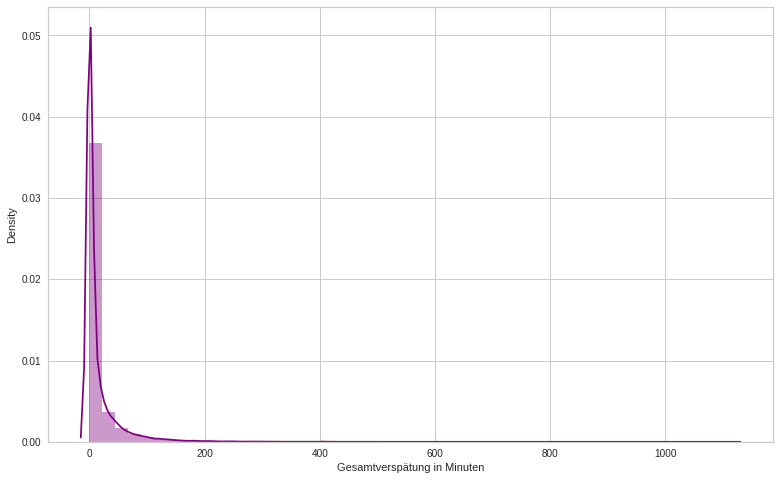

In [171]:
plt.figure(figsize=(13,8))
sns.distplot(data['Gesamtverspätung in Minuten'], color='purple');

In [172]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Box(y=data['Gesamtverspätung in Minuten'], notched=True, name='Gesamtverspätung in Minuten', marker_color = '#6699ff', 
                     boxmean=True, boxpoints='suspectedoutliers'), 1, 2)

fig.update_layout(title_text='Boxplot für die Gesamtverspätung')

fig.show()

###2.5.4 Punkte Zufriedenheit summiert

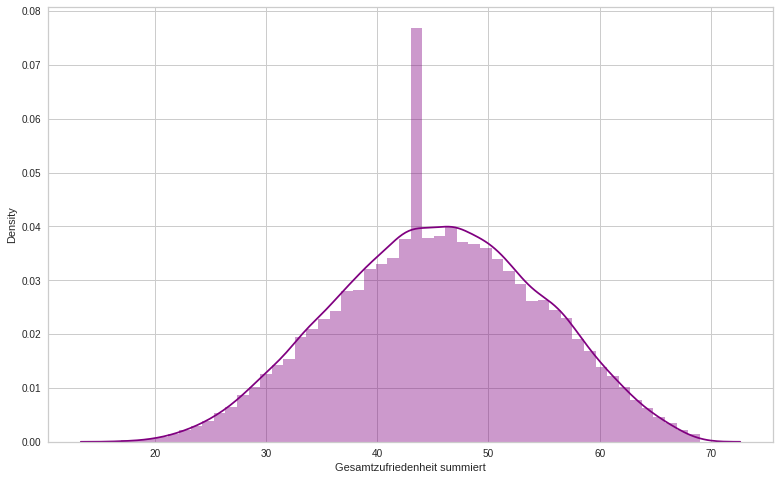

In [176]:
plt.figure(figsize=(13,8))
sns.distplot(data['Gesamtzufriedenheit summiert'], color='purple');

In [177]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Box(y=data['Gesamtzufriedenheit summiert'], notched=True, name='Gesamtzufriedenheit summiert', marker_color = '#6699ff', 
                     boxmean=True, boxpoints='suspectedoutliers'), 1, 2)

fig.update_layout(title_text='Boxplot für die Gesamtzufriedenheit summiert')

fig.show()

##2.6 Kategorienverteilung checken

In [178]:
categorical = [var for var in data.columns if data[var].dtype=='O']
categorical

['Geschlecht', 'Passagier Typ', 'Reisetyp', 'Klasse', 'Ist zufrieden']

In [179]:
#prozentuale Verteilung der Spalten im Bezug zur Gesamtanzahl
for var in categorical:
    print(data[var].value_counts() / np.float(len(data)))
    print("\n\n")

Female    0.506971
Male      0.493029
Name: Geschlecht, dtype: float64



Loyal Customer       0.815317
disloyal Customer    0.184683
Name: Passagier Typ, dtype: float64



Business travel    0.694396
Personal Travel    0.305604
Name: Reisetyp, dtype: float64



Business    0.481095
Eco         0.445062
Eco Plus    0.073842
Name: Klasse, dtype: float64



neutral or dissatisfied    0.561078
satisfied                  0.438922
Name: Ist zufrieden, dtype: float64





###2.6.1 Alle kategorischen Spalten numerisch machen

In [183]:
data.head()

,id,Geschlecht,Passagier Typ,Alter,Reisetyp,Klasse,Flugdistanz,Internet auf dem Flug,Abreise/Ankunft Bequemlichkeit,Leichtigkeit Online Buchung,Standort Gate,Essen und Trinken,Online Boarding,Sitzkomfort,Flugentertainment,On-borading Service,Beinfreiheit,Gepaeckumgang,Checkin Service,Flugservice,Sauberkeit,Abflugverspaetung in Minuten,Gesamtverspätung in Minuten,Ist zufrieden,Gesamtzufriedenheit summiert,Flugverspatung in Minuten,Ist Puenktlich angekommen,Ist Kind,Ist Erwachsener
0,19556,0,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,1,58,-6.0,0,0,1
1,90035,0,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,1,48,0.0,1,0,1
2,12360,1,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,0,30,0.0,1,0,1
3,77959,1,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,1,25,6.0,0,0,1
4,36875,0,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,1,37,20.0,0,0,1


In [182]:
data['Geschlecht'] = data['Geschlecht'].replace({'Female':0, 'Male':1})
data['Ist zufrieden'] = data['Ist zufrieden'].replace({'satisfied':1, 'neutral or dissatisfied':0})